In [1]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4090


In [ ]:
import os
import xml.etree.ElementTree as ET

# 클래스 정의
CLASSES = [
    'BackgroundImage', 'Bottom_Navigation', 'Card', 'CheckBox', 'Checkbox',
    'CheckedTextView', 'Drawer', 'EditText', 'Icon', 'Image', 'Map', 'Modal',
    'Multi_Tab', 'PageIndicator', 'Remember', 'Spinner', 'Switch', 'Text',
    'TextButton', 'Toolbar', 'UpperTaskBar', 'Button'  
]

# 좌표 변환 함수
def convert_box(size, box):
    dw, dh = 1./size[0], 1./size[1]
    x = (box[0]+box[1])/2.0
    y = (box[2]+box[3])/2.0
    w = box[1]-box[0]
    h = box[3]-box[2]
    return (x*dw, y*dh, w*dw, h*dh)

# VOC → YOLO 변환 함수
def convert_voc_to_yolo(xml_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    
    for xml_file in os.listdir(xml_folder):
        if not xml_file.endswith(".xml"):
            continue

        tree = ET.parse(os.path.join(xml_folder, xml_file))
        root = tree.getroot()

        size = root.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        file_id = os.path.splitext(xml_file)[0]
        output_path = os.path.join(output_folder, f"{file_id}.txt")

        with open(output_path, "w") as out_file:
            for obj in root.iter("object"):
                cls = obj.find("name").text
                if cls not in CLASSES:
                    continue
                cls_id = CLASSES.index(cls)

                xmlbox = obj.find("bndbox")
                b = (
                    float(xmlbox.find("xmin").text),
                    float(xmlbox.find("xmax").text),
                    float(xmlbox.find("ymin").text),
                    float(xmlbox.find("ymax").text)
                )
                bb = convert_box((w, h), b)
                out_file.write(f"{cls_id} {' '.join([str(a) for a in bb])}\n")


In [3]:
convert_voc_to_yolo("All Dataset 2/Android/Annotations", "labels_all")
convert_voc_to_yolo("All Dataset 2/iphone/Annotations", "labels_all")
convert_voc_to_yolo("All Dataset 2/Rico/Annotations", "labels_all")
convert_voc_to_yolo("All Dataset 2/uplabs/Annotations", "labels_all")
convert_voc_to_yolo("All Dataset 2/Wireframes/Annotations", "labels_all")


In [4]:
import shutil
import random

def split_dataset(img_src, label_src, train_ratio=0.8):
    imgs = [f for f in os.listdir(img_src) if f.endswith('.jpg')]
    random.shuffle(imgs)
    split_idx = int(len(imgs) * train_ratio)
    train, val = imgs[:split_idx], imgs[split_idx:]

    for mode in ['train', 'val']:
        os.makedirs(f"images/{mode}", exist_ok=True)
        os.makedirs(f"labels/{mode}", exist_ok=True)

    for img in train:
        shutil.copy(os.path.join(img_src, img), f"images/train/{img}")
        shutil.copy(os.path.join(label_src, img.replace('.jpg', '.txt')), f"labels/train/{img.replace('.jpg', '.txt')}")

    for img in val:
        shutil.copy(os.path.join(img_src, img), f"images/val/{img}")
        shutil.copy(os.path.join(label_src, img.replace('.jpg', '.txt')), f"labels/val/{img.replace('.jpg', '.txt')}")

split_dataset("All Dataset 2/Android/JPEGImages", "labels_all")
split_dataset("All Dataset 2/iphone/JPEGImages", "labels_all")
split_dataset("All Dataset 2/Rico/JPEGImages", "labels_all")
split_dataset("All Dataset 2/uplabs/JPEGImages", "labels_all")
split_dataset("All Dataset 2/Wireframes/JPEGImages", "labels_all")


In [5]:
import yaml
import os

data = {
    'train': os.path.abspath('images/train'),
    'val': os.path.abspath('images/val'),
    'nc': len(CLASSES),
    'names': CLASSES
}

with open("data.yaml", 'w') as f:
    yaml.dump(data, f)


In [6]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")
model.train(data="data.yaml", epochs=30, batch=32, imgsz=640)

100%|██████████| 49.7M/49.7M [00:05<00:00, 9.49MB/s]


New https://pypi.org/project/ultralytics/8.3.152 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, o

100%|██████████| 5.35M/5.35M [00:00<00:00, 9.57MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 6442.2±759.6 MB/s, size: 328.9 KB)


train: Scanning /home/serapark/projects/yolo_project/vins_detection/labels/train... 3844 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3844/3844 [00:01<00:00, 1967.13it/s]

train: /home/serapark/projects/yolo_project/vins_detection/images/train/5131.jpg: 1 duplicate labels removed
train: /home/serapark/projects/yolo_project/vins_detection/images/train/IMG_9195.jpg: 1 duplicate labels removed
train: New cache created: /home/serapark/projects/yolo_project/vins_detection/labels/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3098.0±2677.9 MB/s, size: 119.9 KB)


val: Scanning /home/serapark/projects/yolo_project/vins_detection/labels/val... 963 images, 0 backgrounds, 0 corrupt: 100%|██████████| 963/963 [00:00<00:00, 1059.17it/s]


val: New cache created: /home/serapark/projects/yolo_project/vins_detection/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000385, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      12.5G      0.833       1.49     0.9946         61        640: 100%|██████████| 121/121 [00:29<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.90it/s]

                   all        963      13392      0.768      0.517       0.53      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      12.8G     0.6024     0.7071        0.9         50        640: 100%|██████████| 121/121 [00:27<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.88it/s]

                   all        963      13392      0.643      0.583      0.598       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      12.7G     0.5732     0.6363     0.8859        101        640: 100%|██████████| 121/121 [00:27<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.02it/s]

                   all        963      13392      0.689      0.561      0.603      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30        13G     0.5589     0.5995     0.8774        134        640: 100%|██████████| 121/121 [00:27<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.92it/s]

                   all        963      13392      0.711      0.602      0.636      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      12.2G     0.5432     0.5708     0.8755        110        640: 100%|██████████| 121/121 [00:27<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.90it/s]

                   all        963      13392      0.738      0.628      0.652      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30        13G     0.5202     0.5504     0.8688        105        640: 100%|██████████| 121/121 [00:27<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.84it/s]

                   all        963      13392      0.771       0.64       0.68      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      12.3G     0.5067     0.5185     0.8618         87        640: 100%|██████████| 121/121 [00:28<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.83it/s]

                   all        963      13392      0.814      0.643      0.666      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      12.2G     0.4969     0.5041     0.8591         96        640: 100%|██████████| 121/121 [00:27<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.86it/s]

                   all        963      13392      0.856      0.625      0.699      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      12.4G     0.4825     0.4692     0.8538        110        640: 100%|██████████| 121/121 [00:27<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.55it/s]

                   all        963      13392      0.785      0.653      0.697      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      12.6G      0.471     0.4588     0.8482         94        640: 100%|██████████| 121/121 [00:27<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.65it/s]

                   all        963      13392      0.771       0.68      0.706      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      12.2G     0.4651     0.4454     0.8453         96        640: 100%|██████████| 121/121 [00:27<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.56it/s]

                   all        963      13392      0.787      0.666      0.709      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      12.2G     0.4493      0.425      0.842        133        640: 100%|██████████| 121/121 [00:27<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.16it/s]

                   all        963      13392      0.777      0.672      0.696      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      12.3G     0.4451     0.4195     0.8406         79        640: 100%|██████████| 121/121 [00:27<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.88it/s]

                   all        963      13392      0.796       0.65      0.708      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      12.7G      0.439     0.4061     0.8399        109        640: 100%|██████████| 121/121 [00:27<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.90it/s]

                   all        963      13392      0.819      0.661      0.732      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      12.3G     0.4322     0.4061     0.8377        144        640: 100%|██████████| 121/121 [00:27<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.18it/s]

                   all        963      13392      0.782      0.667      0.723      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      12.7G     0.4307     0.4052     0.8366        140        640: 100%|██████████| 121/121 [00:27<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.02it/s]

                   all        963      13392      0.763       0.73       0.73      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      12.1G     0.4262     0.3924     0.8354         72        640: 100%|██████████| 121/121 [00:27<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.09it/s]

                   all        963      13392      0.791      0.672       0.72      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30        13G     0.4241     0.3843     0.8358         59        640: 100%|██████████| 121/121 [00:27<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.77it/s]

                   all        963      13392      0.713      0.717       0.72      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      12.1G     0.4128      0.371     0.8302         90        640: 100%|██████████| 121/121 [00:27<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.82it/s]

                   all        963      13392      0.741       0.68      0.725      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      12.6G     0.4058     0.3595     0.8298        115        640: 100%|██████████| 121/121 [00:27<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.95it/s]

                   all        963      13392      0.821      0.669      0.724      0.678


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      12.4G     0.4034     0.3564     0.8087         68        640: 100%|██████████| 121/121 [00:27<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.85it/s]

                   all        963      13392      0.801      0.677      0.728      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      12.5G     0.3954      0.342      0.807         61        640: 100%|██████████| 121/121 [00:27<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.85it/s]

                   all        963      13392       0.84      0.686      0.735      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      12.5G     0.3901     0.3359     0.8064         94        640: 100%|██████████| 121/121 [00:27<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.80it/s]

                   all        963      13392      0.822      0.711      0.746      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      12.6G     0.3787     0.3163     0.8014         91        640: 100%|██████████| 121/121 [00:27<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.70it/s]

                   all        963      13392      0.733      0.737      0.737      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      12.5G     0.3728     0.3038     0.7999         37        640: 100%|██████████| 121/121 [00:27<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.76it/s]

                   all        963      13392      0.712      0.748      0.737      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      12.6G     0.3667      0.296     0.8002         58        640: 100%|██████████| 121/121 [00:27<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.01it/s]

                   all        963      13392      0.841      0.745      0.753      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      12.5G     0.3571     0.2846     0.7974         33        640: 100%|██████████| 121/121 [00:27<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.69it/s]

                   all        963      13392      0.927      0.712      0.754      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      12.5G     0.3538     0.2777     0.7981         39        640: 100%|██████████| 121/121 [00:27<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]

                   all        963      13392      0.914      0.735      0.773      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      12.5G     0.3461     0.2675     0.7932         63        640: 100%|██████████| 121/121 [00:26<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.98it/s]

                   all        963      13392      0.897      0.736      0.754      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      12.6G     0.3422     0.2586     0.7964         43        640: 100%|██████████| 121/121 [00:27<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.09it/s]

                   all        963      13392      0.886       0.73      0.757      0.716



30 epochs completed in 0.262 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.16 torch-2.7.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
Model summary (fused): 92 layers, 25,852,498 parameters, 0 gradients, 78.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:05<00:00,  2.83it/s]


                   all        963      13392      0.914      0.735      0.771      0.727
       BackgroundImage        135        140      0.844      0.907      0.934       0.92
     Bottom_Navigation          3          3          1          0      0.351      0.316
                  Card         11         28      0.651      0.393      0.451      0.436
              Checkbox          1          1          1          0          0          0
       CheckedTextView         57        174      0.864      0.943      0.972      0.863
                Drawer         59         59      0.965          1      0.995      0.995
              EditText        244        515      0.956      0.979      0.987      0.956
                  Icon        609       2391      0.901      0.929      0.955       0.85
                 Image        735       1663      0.871      0.878      0.932      0.891
                 Modal         67         67      0.992      0.896       0.97      0.954
             Multi_Ta

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  4,  5,  6,  7,  8,  9, 11, 12, 13, 15, 16, 17, 18, 19, 20])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f1310a73400>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    

In [ ]:
results = model.predict(source='images/val', save=True)


image 1/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10555.jpg: 640x416 1 Drawer, 9 Icons, 3 Images, 1 Switch, 10 Texts, 1 UpperTaskBar, 25.5ms
image 2/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10583.jpg: 640x416 2 Icons, 6 Images, 1 Modal, 9 Texts, 1 UpperTaskBar, 7.3ms
image 3/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10586.jpg: 640x416 5 Icons, 1 Image, 6 Texts, 1 Toolbar, 1 UpperTaskBar, 7.4ms
image 4/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10599.jpg: 640x416 1 Icon, 3 Texts, 1 Toolbar, 1 UpperTaskBar, 7.3ms
image 5/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10601.jpg: 640x416 2 Icons, 2 Images, 1 Modal, 4 Texts, 1 TextButton, 1 UpperTaskBar, 7.3ms
image 6/963 /home/serapark/projects/yolo_project/vins_detection/images/val/10624.jpg: 640x416 1 BackgroundImage, 1 Icon, 1 Image, 4 Texts, 1 TextButton, 1 UpperTaskBar, 9.1ms
image 7/963 /home/serapark/projects/yolo

In [8]:
# MS COCO 데이터셋이 아닌 VINS 데이터셋으로 변경되었는지 확인
print(type(model.names), len(model.names))
print(model.names)

<class 'dict'> 22
{0: 'BackgroundImage', 1: 'Bottom_Navigation', 2: 'Card', 3: 'CheckBox', 4: 'Checkbox', 5: 'CheckedTextView', 6: 'Drawer', 7: 'EditText', 8: 'Icon', 9: 'Image', 10: 'Map', 11: 'Modal', 12: 'Multi_Tab', 13: 'PageIndicator', 14: 'Remember', 15: 'Spinner', 16: 'Switch', 17: 'Text', 18: 'TextButton', 19: 'Toolbar', 20: 'UpperTaskBar', 21: 'Button'}


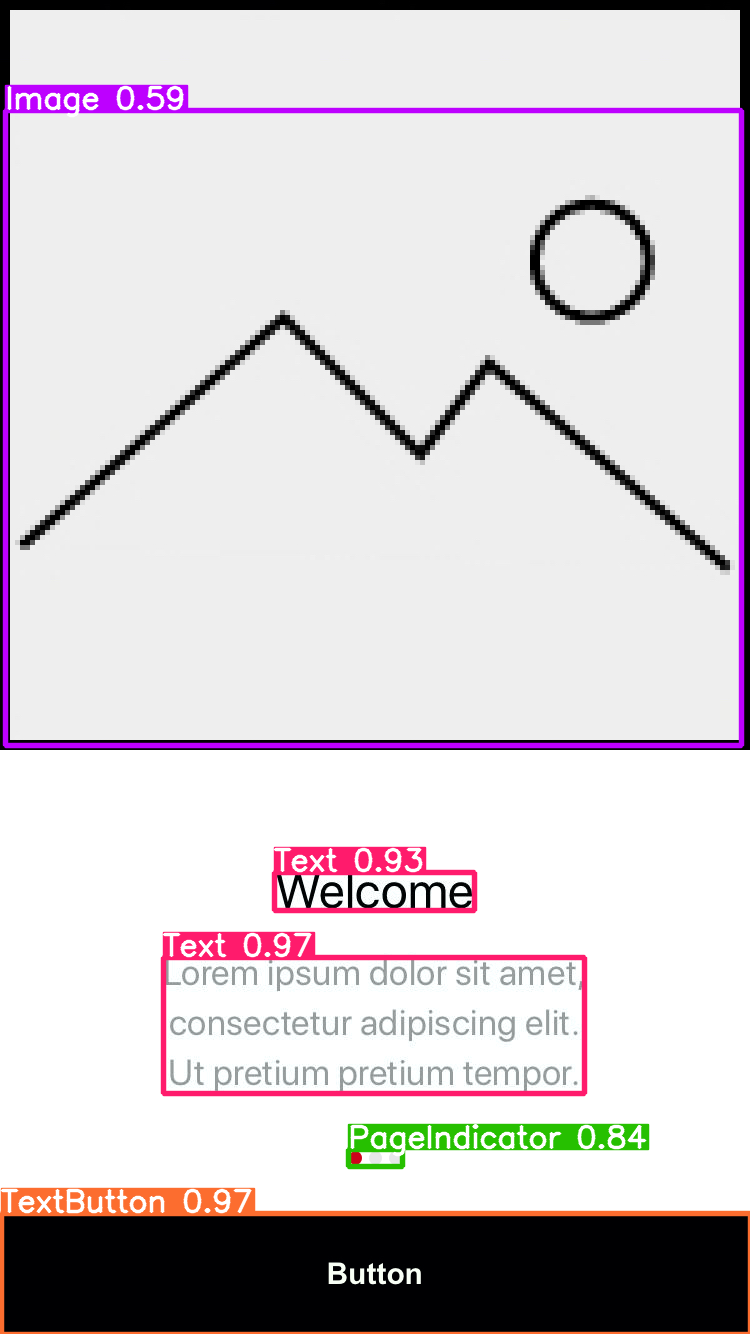

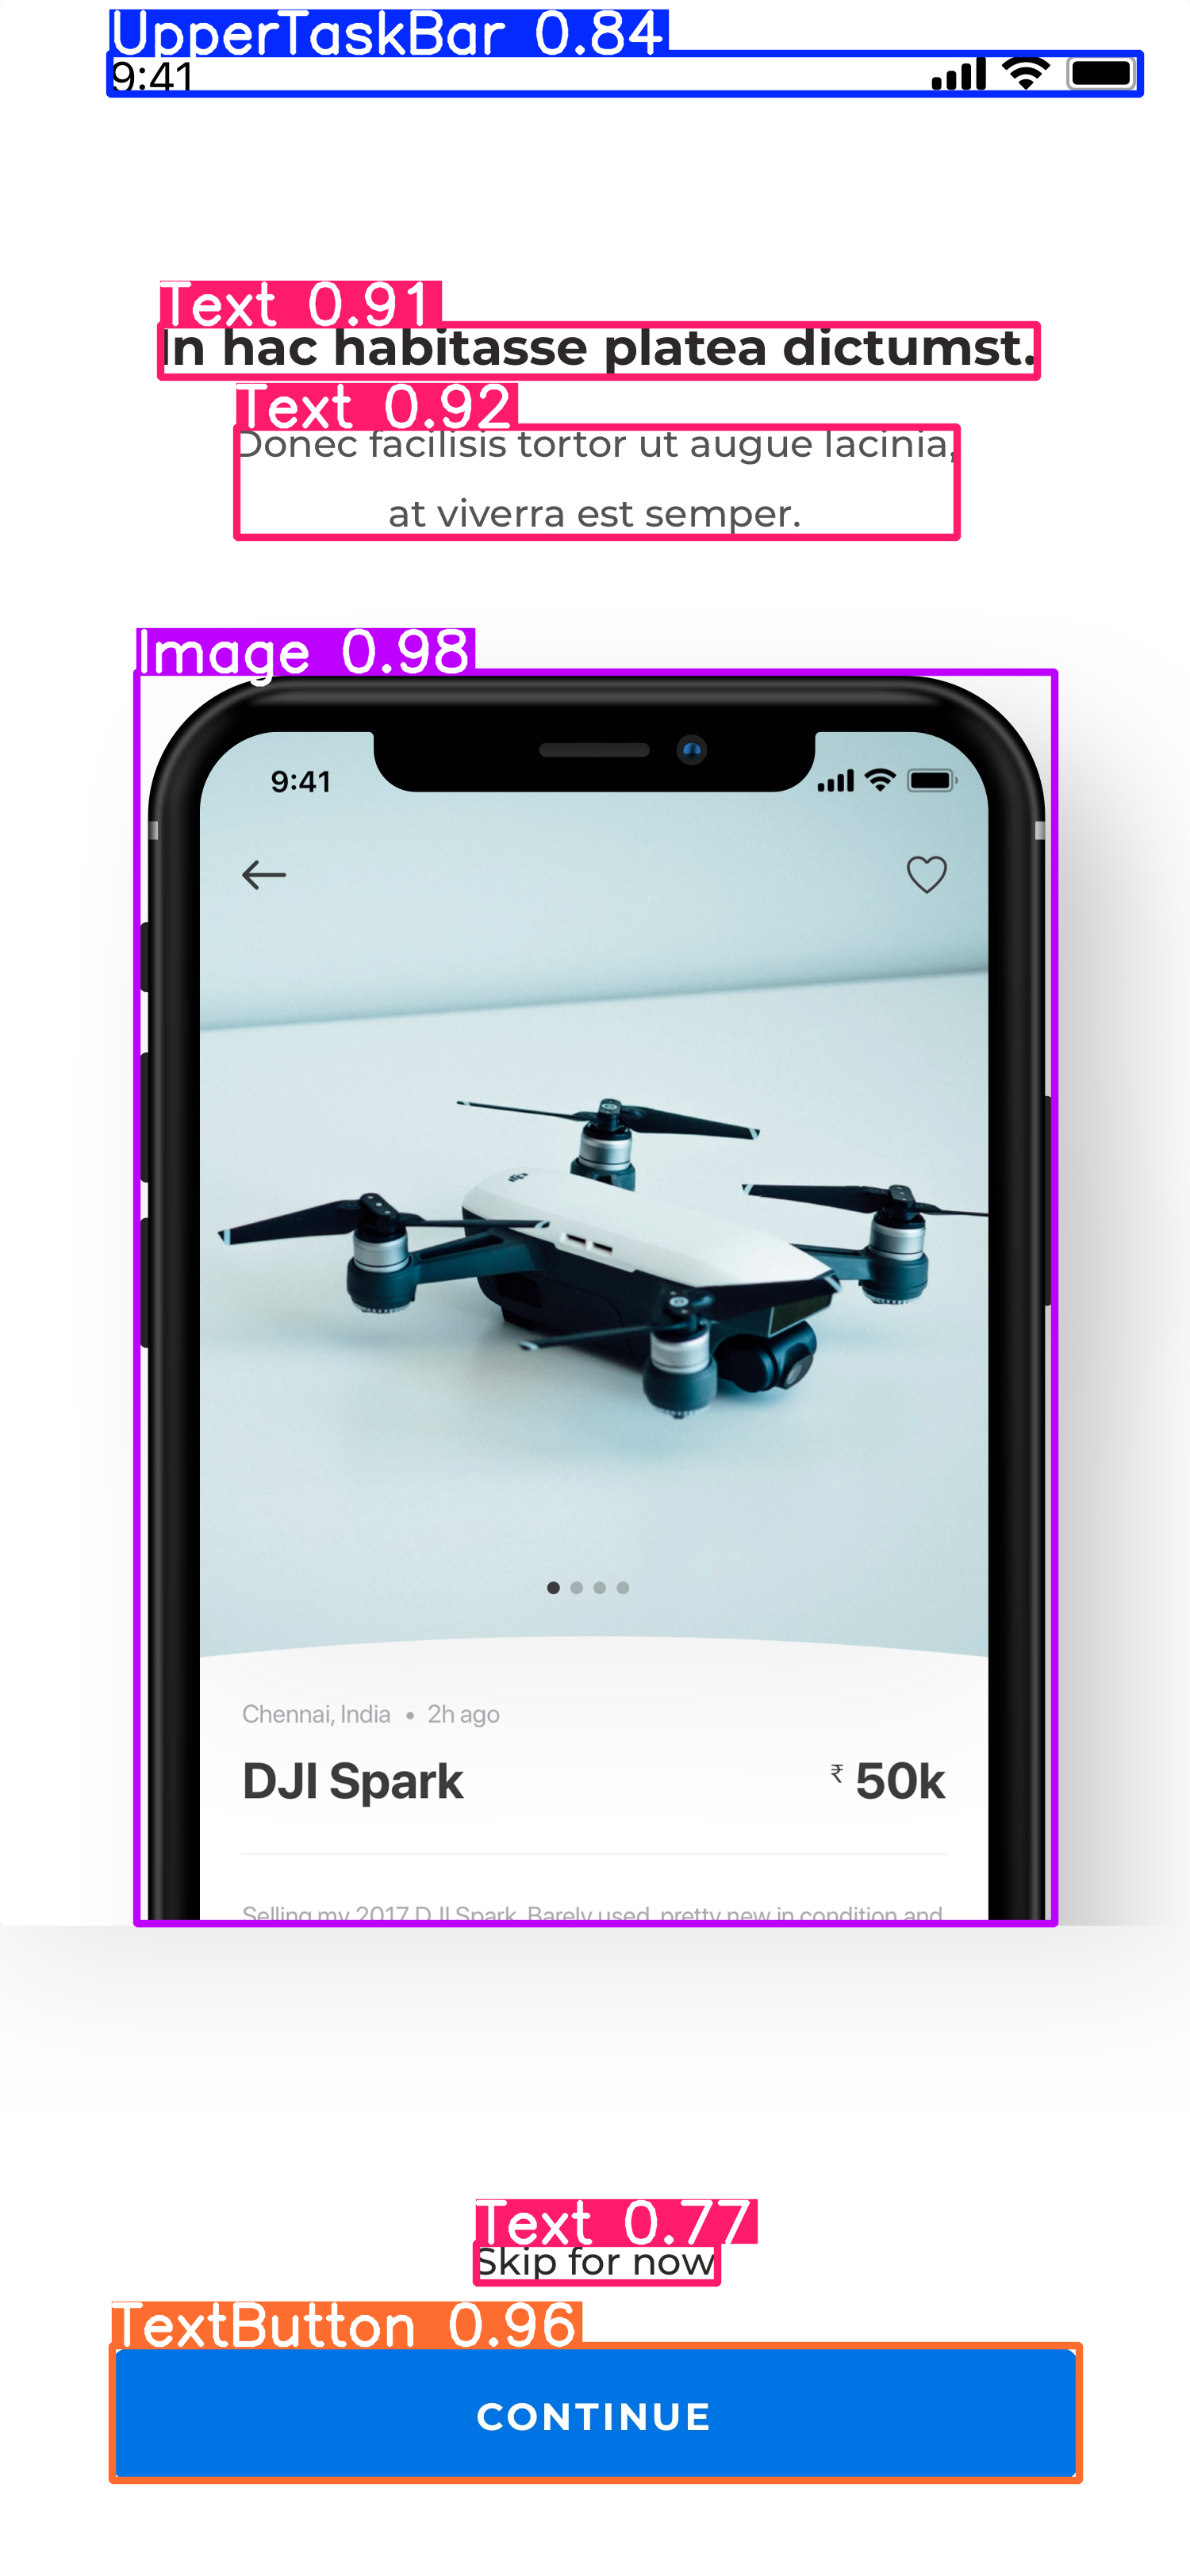

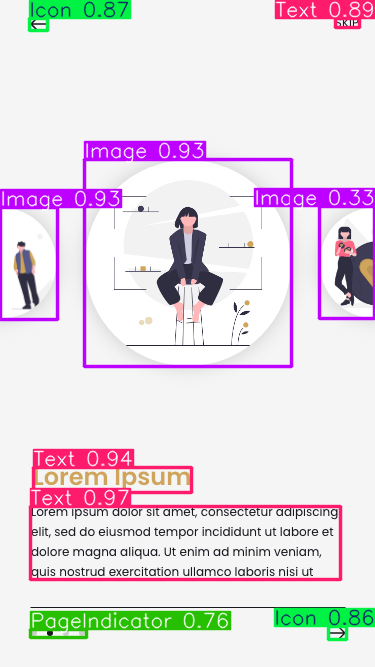

In [9]:
import random
for r in random.sample(results, 3):
    r.show()

In [10]:
import cv2
import numpy as np

# 클래스별 색상, 모서리 출력 기준 설정
STYLE_CAPABILITY = {
    "BackgroundImage":   {"color": True, "edge": False},
    "Bottom_Navigation": {"color": True, "edge": True},
    "Card":              {"color": True, "edge": True},
    "CheckBox":          {"color": True, "edge": True},
    "Checkbox":          {"color": True, "edge": True},
    "CheckedTextView":   {"color": True, "edge": True},
    "Drawer":            {"color": True, "edge": False},
    "EditText":          {"color": True, "edge": True},
    "Icon":              {"color": True, "edge": True},
    "Image":             {"color": True, "edge": True},
    "Map":               {"color": False, "edge": False},
    "Modal":             {"color": True, "edge": True},
    "Multi_Tab":         {"color": True, "edge": True},
    "PageIndicator":     {"color": True, "edge": True},
    "Remember":          {"color": True, "edge": False},
    "Spinner":           {"color": True, "edge": True},
    "Switch":            {"color": True, "edge": True},
    "Text":              {"color": True, "edge": False},
    "TextButton":        {"color": True, "edge": True},
    "Toolbar":           {"color": True, "edge": True},
    "UpperTaskBar":      {"color": True, "edge": True},
    "Button":            {"color": True, "edge": True}
}

# 색상 이름 출력 기준 설정
def ui_color(bgr):
    hsv = cv2.cvtColor(np.uint8([[bgr]]), cv2.COLOR_BGR2HSV)[0][0]
    h, s, v = hsv
    
    if s < 30 and v > 200:
        return "White"
    elif v < 50:
        return "Black"
    elif s < 30:
        return "Gray"

    if (176 <= h <= 179) or (0 <= h <= 3):
        return "Red"
    elif 4 <= h <= 11:
        return "Red-Orange"
    elif 12 <= h <= 18:
        return "Orange"
    elif 19 <= h <= 25:
        return "Orange-Yellow"
    elif 26 <= h <= 33:
        return "Yellow"
    elif 34 <= h <= 40:
        return "Yellow-Chartreuse"
    elif 41 <= h <= 48:
        return "Chartreuse"
    elif 49 <= h <= 55:
        return "Chartreuse-Green"
    elif 56 <= h <= 63:
        return "Green"
    elif 64 <= h <= 70:
        return "Spring Green"
    elif 71 <= h <= 78:
        return "Spring Green-Cyan"
    elif 79 <= h <= 85:
        return "Cyan"
    elif 86 <= h <= 93:
        return "Cyan-Azur"
    elif 94 <= h <= 100:
        return "Azure"
    elif 101 <= h <= 108:
        return "Azure-Blue"
    elif 109 <= h <= 115:
        return "Blue"
    elif 116 <= h <= 123:
        return "Blue-Violet"
    elif 124 <= h <= 130:
        return "Violet"
    elif 131 <= h <= 138:
        return "Violet-Magenta"
    elif 139 <= h <= 145:
        return "Magenta"
    elif 146 <= h <= 153:
        return "Magenta-Rose"
    elif 154 <= h <= 160:
        return "Rose"
    elif 161 <= h <= 168:
        return "Rose-Red"
    elif 169 <= h <= 175:
        return "Red"
    else:
        return "Unknown"

# 모서리 sharp, curve 판단
def ui_contour(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        epsilon = 0.05 * cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, epsilon, True)

        # 꼭짓점 수가 많으면 curve로 간주
        if len(approx) > 6:
            return True

    # 대부분 직선이면 sharp로 간주
    return False


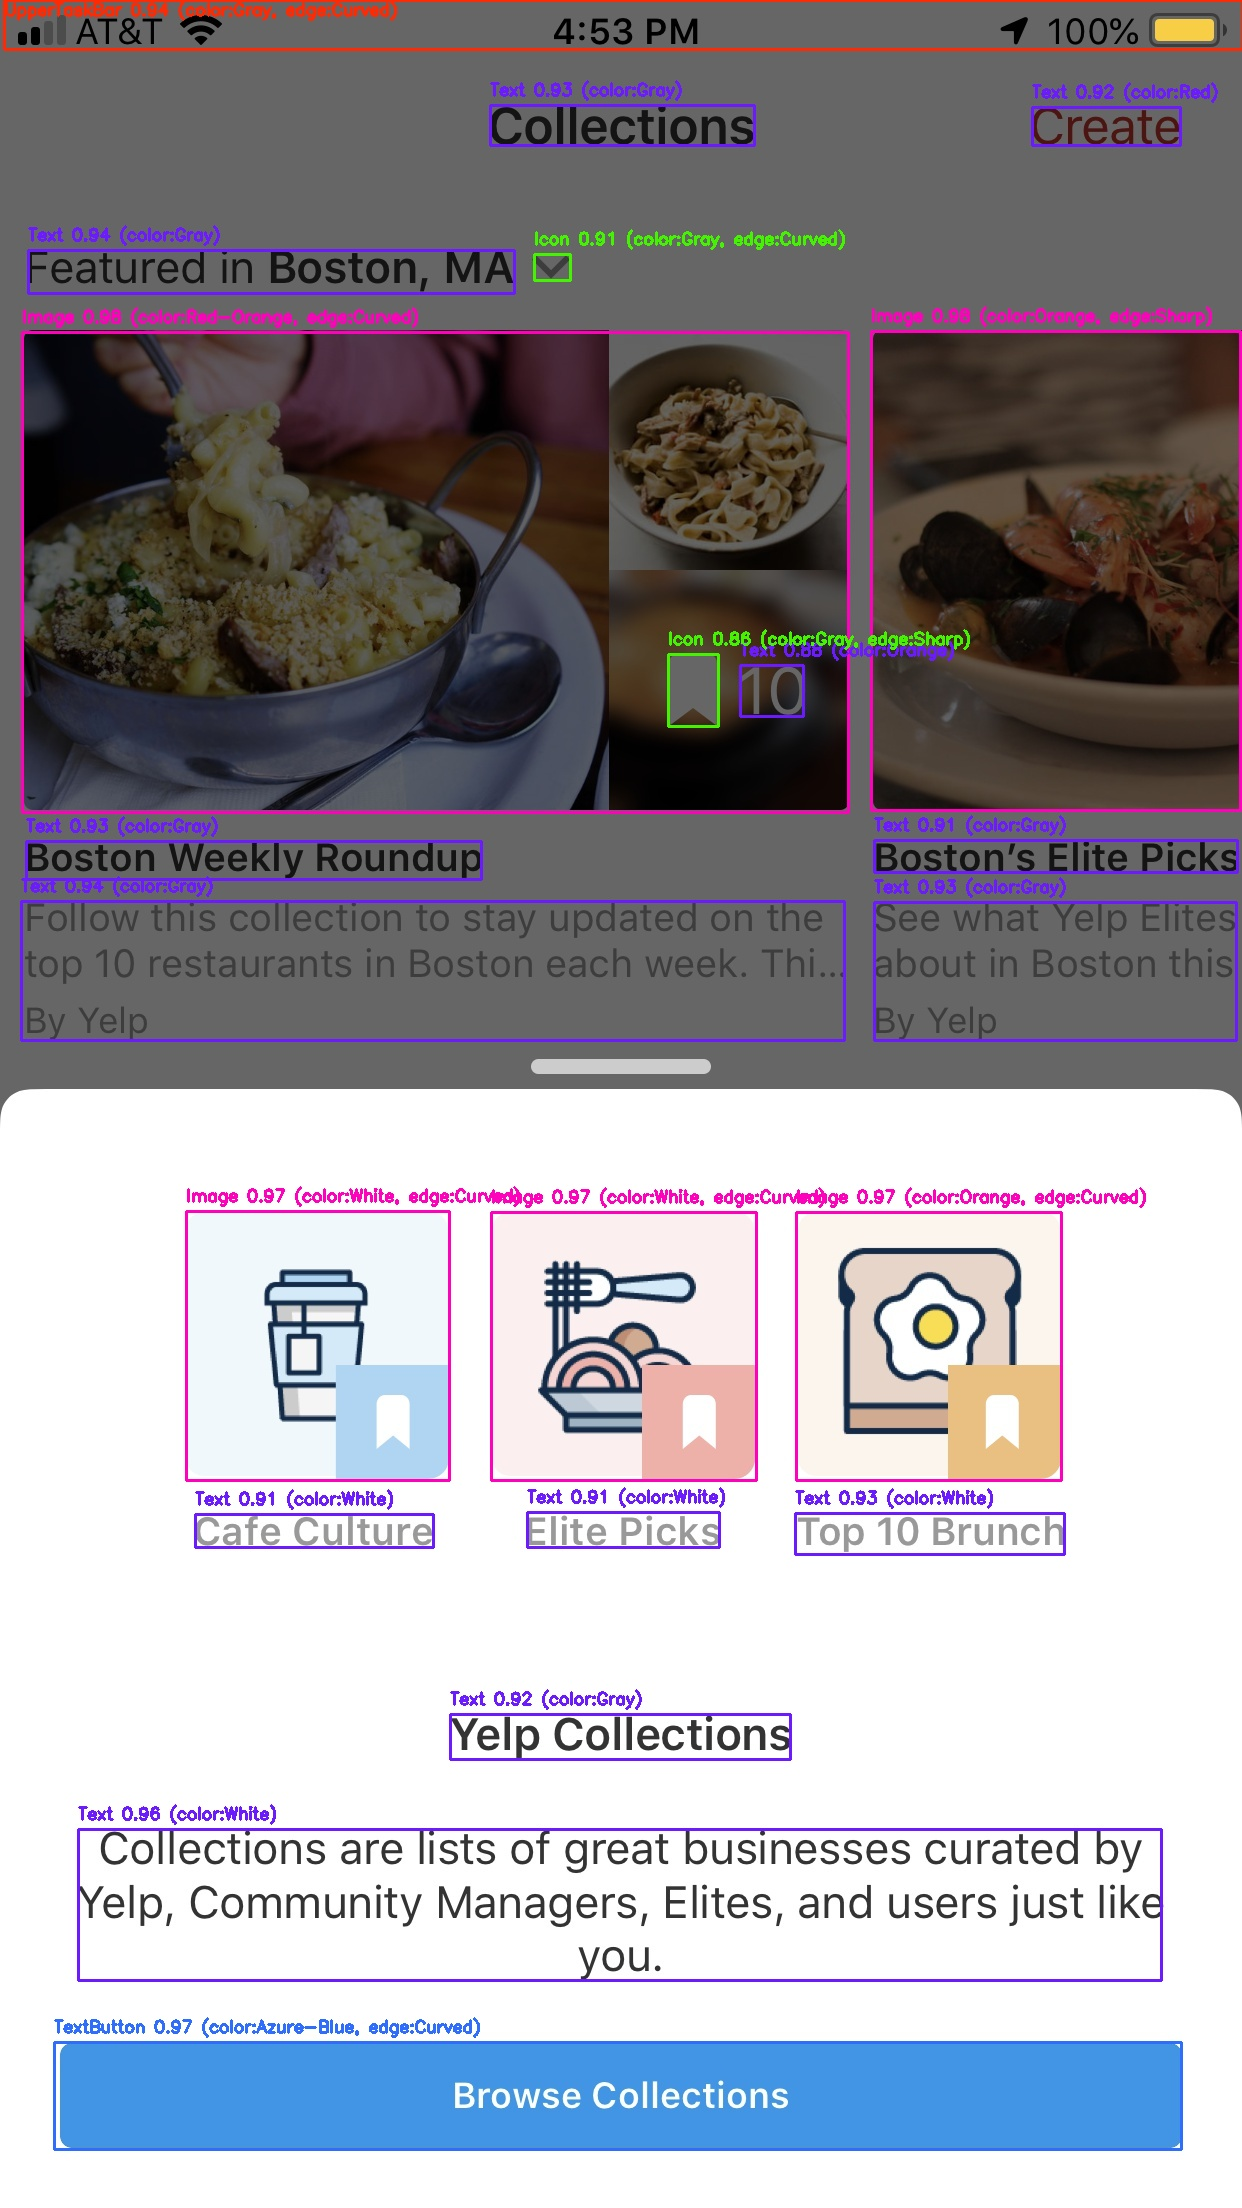

In [ ]:
from ultralytics.utils.plotting import Colors
colors = Colors()

# 이미지 1장 랜덤하게 출력
for r in random.sample(results, 1):
    image = r.orig_img.copy()

    for bbox in r.boxes:
        cls_id = int(bbox.cls[0])
        cls_name = model.names[cls_id]

        # 바운딩 박스 좌표
        x1, y1, x2, y2 = map(int, bbox.xyxy[0])
        crop = image[y1:y2, x1:x2]

        # 객체 라벨에 추가할 스타일 정보 초기화
        info = STYLE_CAPABILITY.get(cls_name, {"color" : False, "edge": False})
        parts = [f"{cls_name} {bbox.conf[0]:.2f}"]

        # 색상 분석
        if info["color"]:
            avg_color = crop.mean(axis=(0, 1)).astype(np.uint8)
            parts.append(f"color:{ui_color(avg_color)}")

        # 모서리 분석
        if info["edge"]:
            edge = "Curved" if ui_contour(crop) else "Sharp"
            parts.append(f"edge:{edge}")

        # 객체 탐지, 색상, 모서리 포함 라벨 생성
        label = "(" + ", ".join(parts[1:]) + ")" if len(parts) > 1 else "" 
        label = f"{parts[0]} {label}".strip()

        # 시각화
        box_color = colors(cls_id)
        cv2.rectangle(image, (x1, y1), (x2, y2), box_color, 2)
        cv2.putText(image, label, (x1, max(y1 - 10, 15)), cv2.FONT_HERSHEY_SIMPLEX, 0.55, box_color, 2)

# 이미지 출력
from PIL import Image
from IPython.display import display

cv2.imwrite("ui_result.jpg", image)
display(Image.open("ui_result.jpg"))